<a href="https://colab.research.google.com/github/BRUNO-FEVE/CSS-Cheatsheet-Codecademy/blob/main/Projeto_Raca_Cachorro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introdução à inteligência artificial

##Projeto final - Classificação de raça de cachorro
Este arquivo deve ser entregue até dia 03/08/21. Para isso, adicione o seu RA no título do arquivo.
A finalidade deste projeto é modificar o **classificador** de uma rede neural previamente treinada, onde fica a seu critério escolher qual arquitetura do modelo VGG você irá utilizar. 
Será avaliado quais foram as camadas utilizadas, funções de ativação, métodos para evitar *overfitting*, critério de perda, otimizador e quaisquer outros métodos que alterem os hiperparâmetros da rede.

A precisão percentual será calculada pelo algoritmo no final deste arquivo.

### Importação de biblioteca e dados

In [ ]:
# Download do dataset
!if [[ ! -e dataset.tar ]]; then wget -O dataset.tar http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar; fi
# Descomprimir a pasta com as imagens
!if [[ ! -d Images ]]; then tar -xvf dataset.tar; fi

In [2]:
# Importação das bibliotecas
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import os
import copy
import itertools
import time
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
from google.colab import files

In [3]:
# Classe auxiliar para aplicar transformadas em cada dataset separado
class ApplyTransform(Dataset):
    def __init__(self, dataset, transform=None, target_transform=None):
        self.dataset = dataset
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, idx):
        sample, target = self.dataset[idx]
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return sample, target

    def __len__(self):
        return len(self.dataset)

### Definição das transformações e tamanho de lote

In [4]:
# Escolha um valor conforme informado anteriormente
# Quantas amostras por lote 
batch_size = 21
test_valid_size = 0.2

# Define as transformações, fique a vontade para adicionar mais transformações!!!
train_transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
valid_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
test_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

# Importação das imagens para o tipo "dataset"
data_dir = '/content/Images'
image_dataset = datasets.ImageFolder(data_dir)

# Obter índices de treinamento que serão usados para validação
num_train = len(image_dataset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(test_valid_size * num_train))
train_idx, valid_idx , test_idx = indices[split:], indices[:int(np.floor(split/2))], indices[int(np.floor(split/2)):split]

# Definir amostradores para obter lotes de treinamento e validação
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)

# Aplica as transformações para o treino e validação
train_dataset = ApplyTransform(image_dataset, transform=train_transform)
valid_dataset = ApplyTransform(image_dataset, transform=valid_transform)
test_dataset = ApplyTransform(image_dataset, transform=test_transform)

# Preparar carregadores de dados (combinar conjunto de dados e amostrador)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
    sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, 
    sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
    sampler=test_sampler)

# Especifica as classes das imagens
class_names = image_dataset.classes

data_loader = {'train':train_loader,'valid':valid_loader,'test':test_loader}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Funções auxiliares

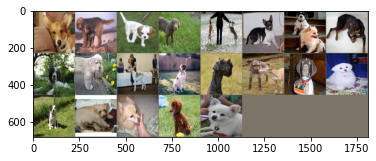

In [5]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
      pass
      #plt.title(title)
    plt.pause(0.001)


# Pega um lote de treinamento
inputs, classes = next(iter(data_loader['train']))

# Faz um "grid" com as imagens
out = torchvision.utils.make_grid(inputs)

# Mostra um lote de imagens
imshow(out, title=[class_names[x] for x in classes])

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Época {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Cada época tem uma fase de treino e validação
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Modelo em treinamento
            else:
                model.eval()   # Modelo em avaliação

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in data_loader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zera o gradiente do otimizador
                optimizer.zero_grad()

                # Analisa somente as perdas se for no treinamento
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 'loss.backward()' + 'optimizer.step()' somente no treinamento
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Estatisticas
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / (len(data_loader[phase])*batch_size)
            epoch_acc = running_corrects.double() / (len(data_loader[phase])*batch_size)

            print('{} Perda: {:.4f} Precisão: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Copia o modelo
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Treinamento completo em {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Melhor precisão: {:4f}'.format(best_acc))
    torch.save(best_model_wts,"model.pt")

    # Carrega os pesos do melhor modelo
    model.load_state_dict(best_model_wts)
    return model

### Modelo

Utilizaçã de modelo [VGG](https://pytorch.org/vision/stable/models.html) **pré-treinado** para transferir aprendizado com ultima camada "treinável"

In [21]:
# Definição do modelo
model = nn.Sequential(nn.Linear(50176, 20000),
                      nn.ReLU(),
                      nn.Linear(20000, 5000),
                      nn.ReLU(),
                      nn.Linear(5000, 21))

for param in model.parameters():
    param.requires_grad = False
   
# Quantidade de entradas do classificador antigo
num_ftrs = model.classifier[0].in_features

# Definição do novo classificador com entrada de num_ftrs e saída de len(class_names)
model.classifier = NotImplemented

# Move o modelo para o dispositivo disponivel
model = model.to(device)

# Definição do critério
criterion = NotImplemented

# Definição do otimizador
optimizer = NotImplemented

# Definição do "scheduler"
exp_lr_scheduler = NotImplemented

AttributeError: ignored

### Treinamento

In [ ]:
model = train_model(model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=3)

### Carregar o modelo

In [ ]:
# Carrega o modelo 
file_name = "model.pt"
model.load_state_dict(torch.load(file_name))

### Avaliação do projeto

In [ ]:
# Teste final para avaliação da rede
test_loss = 0.0
class_correct = list(0. for i in range(len(class_names)))
class_total = list(0. for i in range(len(class_names)))

train_on_gpu = torch.cuda.is_available()
model.eval()

for batch_idx, (data, target) in enumerate(data_loader['test']):
    # Move os tensores para a GPU se disponivel
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # Inferência 
    output = model(data)
    # Calcula a perda
    loss = criterion(output, target)
    # Atualiza a perda
    test_loss += loss.item()*data.size(0)
    # Convert as probabilidades para classe e escolhe somente a maior
    _, pred = torch.max(output, 1)    
    # Compara as predições com a classe verdadeira
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # Calcula a precisão para cada objeto
    for i in range(batch_size):
        label = target.data[i]
        if(correct.size==batch_size):
          class_correct[label] += correct[i].item()
          class_total[label] += 1

# Perda média
test_loss = test_loss/len(test_loader.dataset)
print('Perda de teste: {:.6f}\n'.format(test_loss))

for i in range(len(class_names)):
    if class_total[i] > 0:
      name = class_names[i][10:].replace(' ', '').capitalize()
      print('Precisão de teste de %5s: %2d%% (%2d/%2d)' % (
            name, 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Precisão de teste de %5s: N/A (sem dados de treinamento)' % (class_names[i]))
overall_acc = 100. * np.sum(class_correct) / np.sum(class_total)
print('\nPrecisão de teste geral: %6.2f%% (%3d/%3d)' % (
    overall_acc,
    np.sum(class_correct), np.sum(class_total)))

### Insira sua imagem (opcional)

In [ ]:
 files.upload()

In [ ]:
from PIL import Image

# Carrega imagem 
image = Image.open("download.jpeg")
# Aplica transformações
input_image = test_transform(image)
# Entra em modo de avaliação
model.eval()
# Muda o modelo para a CPU
model.to(torch.device("cpu"))
# Faz a inferência
logit = model(input_image.unsqueeze(0))
# Cria uma "camada" de softmax
softmax = nn.Softmax(dim=1)
# Aplica saida
out = softmax(logit)
# Analisa saida
value, indice = out.topk(3)
# Mostra probabilidade e classe
print("Probabilidade de {} de ser {}".format(float(value[:,0]),class_names[int(indice[:,0])]))
# Mostra probabilidade e classe
print("Probabilidade de {} de ser {}".format(float(value[:,1]),class_names[int(indice[:,1])]))
# Mostra probabilidade e classe
print("Probabilidade de {} de ser {}".format(float(value[:,2]),class_names[int(indice[:,2])]))